In [1]:
import pandas as pd
df= pd.read_csv('/kaggle/input/products-6000/balanced_shuffled_products.csv')
df.head()

,title,category_id,category_name
0,Ratatouille - PC/Mac,248,Mac Games & Accessories
1,OKAY SHEA BUTTER JAR WHITE 13oz weight (16oz j...,52,Personal Care Products
2,Fox Baby Shower Thank You Cards Woodland Fores...,40,Baby Stationery
3,Factual Upcycled Canvas & Cowhide Messenger Bag,100,Messenger Bags
4,Boley Dinosaur Adventure Road Creators Playset...,240,"Slot Cars, Race Tracks & Accessories"


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Ön İşleme Fonksiyonunu Tanımlama
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Metin değilse boş string döndür (NaN değerleri için)
    if not isinstance(text, str):
        return ""

    # Adım 1: Küçük harfe çevir
    text = text.lower()

    # Adım 2: Özel karakterleri, sayıları ve noktalama işaretlerini kaldır
    # Sadece harfleri ve boşlukları koru
    text = re.sub(r'[^a-z\s]', '', text)

    # Adım 3: Tokenize et (kelimelere ayır)
    tokens = text.split()

    # Adım 4: Lemmatization yap ve stop words'leri kaldır
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Adım 5: Tekrar birleştirerek temiz metni oluştur
    return ' '.join(processed_tokens)


# 2. Fonksiyonu DataFrame'e Uygulama
df['cleaned_title'] = df['title'].apply(preprocess_text)

In [4]:
# 3. Sonucu Kontrol Etme: "Önce" ve "Sonra"
print("\n--- Ön İşleme Örnekleri ---")
print("Orjinal Başlık: ", df['title'].iloc[2])
print("Temizlenmiş Başlık: ", df['cleaned_title'].iloc[2])


--- Ön İşleme Örnekleri ---
Orjinal Başlık:  Fox Baby Shower Thank You Cards Woodland Forest Friends Animals Wreath Flowers Autumn Colors Orange Cream Green Teal Notes (24 count)
Temizlenmiş Başlık:  fox baby shower thank card woodland forest friend animal wreath flower autumn color orange cream green teal note count


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Özellik (X) ve Hedef (y) değişkenlerini belirleme
X = df['cleaned_title']  # Temizlenmiş metinleri özellik olarak kullanıyoruz
y = df['category_name']  # Tahmin edilecek hedef

In [6]:
# Veriyi eğitim ve test setlerine ayırma
# stratify=y -> Eğitim ve test setlerindeki kategori dağılımını korur
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,       # Verinin %15'i test seti olacak
    random_state=42,     # Sonuçların tekrarlanabilir olması için
    stratify=y
)
print(f"Eğitim seti boyutu: {len(X_train)} örnek")
print(f"Test seti boyutu: {len(X_test)} örnek")
print("\n" + "="*60 + "\n")

Eğitim seti boyutu: 5100 örnek
Test seti boyutu: 900 örnek




# 5. TF-IDF VEKTÖRLEŞTİRME


In [7]:
# TF-IDF Vectorizer'ı oluşturma
vectorizer = TfidfVectorizer(
    max_features=5000,    # En önemli 5000 kelimeyi/terimi kullan
    ngram_range=(1, 2)    # Hem tekli kelimeleri hem de ikili kelime gruplarını dikkate al
)

In [8]:
# Vektörleştiriciyi SADECE eğitim verisine göre eğitme ve eğitim verisini dönüştürme
X_train_tfidf = vectorizer.fit_transform(X_train)

# Test verisini ise önceden eğitilmiş vektörleştirici ile SADECE dönüştürme
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF vektörleştirme tamamlandı.")
print(f"Oluşturulan özellik matrisinin boyutu (eğitim): {X_train_tfidf.shape}")
print("\n" + "="*60 + "\n")

TF-IDF vektörleştirme tamamlandı.
Oluşturulan özellik matrisinin boyutu (eğitim): (5100, 5000)




# 6. MODELİ EĞİTME (LOJİSTİK REGRESYON)

In [9]:
# Lojistik Regresyon modelini oluşturma
model = LogisticRegression(max_iter=1000, random_state=42)

print("Lojistik Regresyon modeli eğitiliyor...")
# Modeli eğitim verileriyle eğitme
model.fit(X_train_tfidf, y_train)
print("Model eğitimi tamamlandı.")
print("\n" + "="*60 + "\n")

Lojistik Regresyon modeli eğitiliyor...
Model eğitimi tamamlandı.




In [10]:
# Modelin test seti üzerinde tahmin yapmasını sağlama
y_pred = model.predict(X_test_tfidf)

# Doğruluk (Accuracy) skorunu hesaplama ve yazdırma
accuracy = accuracy_score(y_test, y_pred)
print(f"Modelin Test Verisi Üzerindeki Doğruluğu: {accuracy:.4f} ({accuracy:.2%})")

# Her kategori için detaylı performans metriklerini içeren sınıflandırma raporu
print("\n--- SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test, y_pred))

Modelin Test Verisi Üzerindeki Doğruluğu: 0.9367 (93.67%)

--- SINIFLANDIRMA RAPORU ---
                                                  precision    recall  f1-score   support

                                 Baby Stationery       1.00      0.98      0.99        90
                                  Legacy Systems       0.74      0.87      0.80        90
                         Mac Games & Accessories       0.92      0.84      0.88        90
                                  Messenger Bags       1.00      0.96      0.98        90
Nintendo 3DS & 2DS Consoles, Games & Accessories       0.85      0.82      0.84        90
                                   Oils & Fluids       0.96      0.99      0.97        90
                          Personal Care Products       0.96      0.99      0.97        90
                  Pregnancy & Maternity Products       0.99      0.96      0.97        90
            Slot Cars, Race Tracks & Accessories       0.99      1.00      0.99        90
           



--- SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---


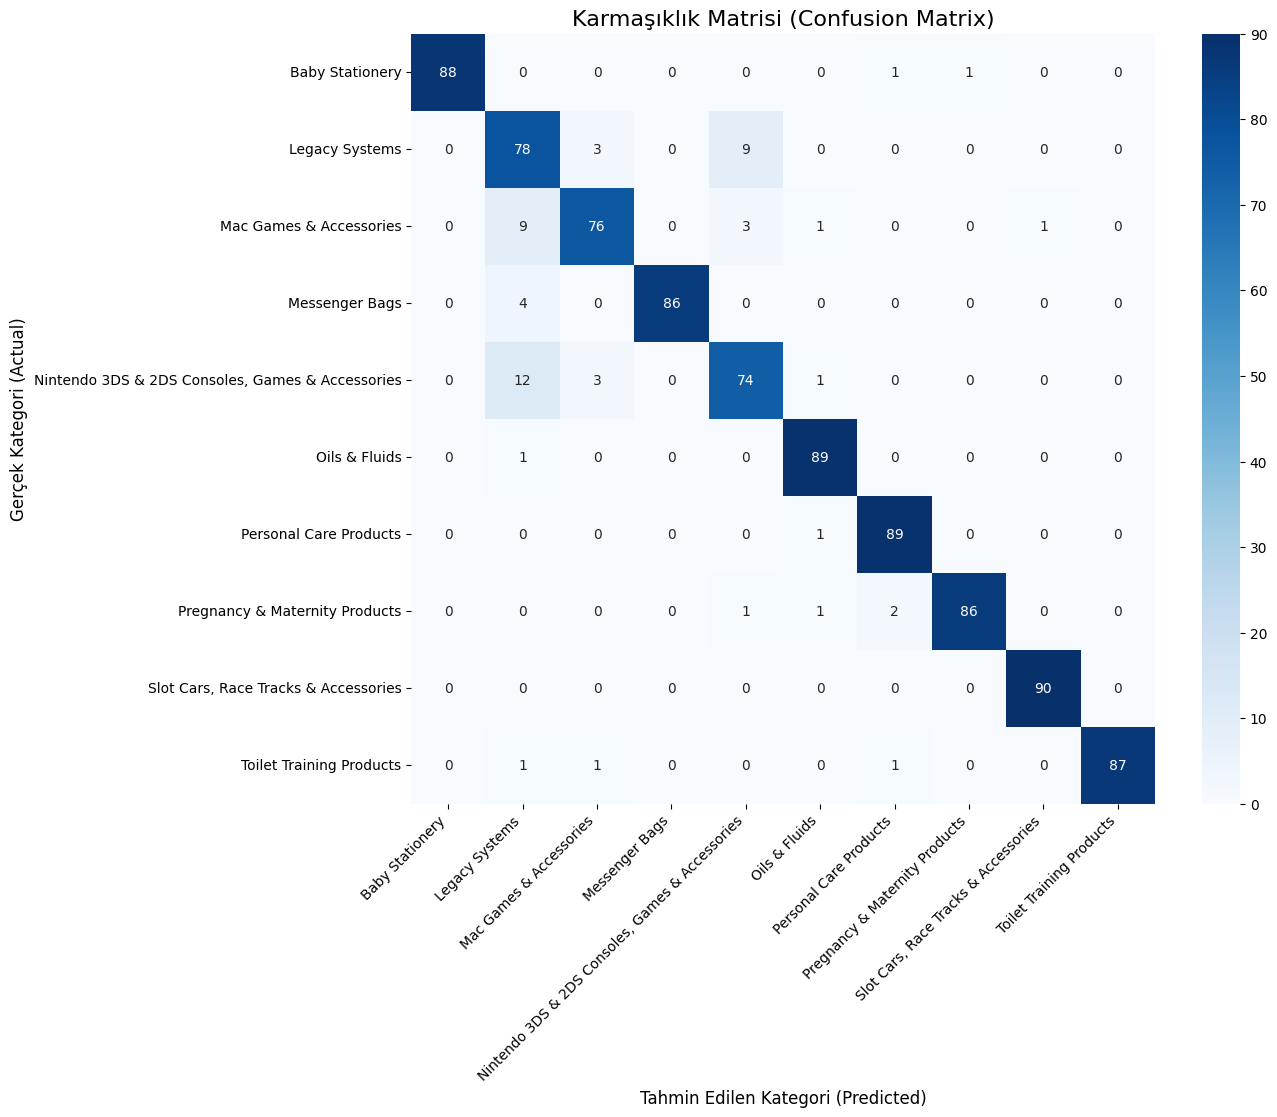

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n" + "="*60 + "\n")
print("--- SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---")

# 1. Karmaşıklık Matrisini (Confusion Matrix) hesaplama
cm = confusion_matrix(y_test, y_pred)

# 2. Matrisin etiketlerini (kategori adlarını) modelden alma
# Bu, eksenlerin doğru sırada olmasını sağlar
class_labels = model.classes_

# 3. Seaborn heatmap kullanarak görselleştirme
plt.figure(figsize=(12, 10)) # Grafiğin boyutunu ayarlama

heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=class_labels, yticklabels=class_labels)

# Eksen etiketlerinin okunabilirliğini artırma
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Karmaşıklık Matrisi (Confusion Matrix)', fontsize=16)
plt.ylabel('Gerçek Kategori (Actual)', fontsize=12)
plt.xlabel('Tahmin Edilen Kategori (Predicted)', fontsize=12)
plt.show()

In [12]:
# 8. YENİ ÖRNEKLERLE TAHMİN YAPMA (INFERENCE)

print("\n" + "="*60 + "\n")
print("--- Yeni Verilerle Örnek Tahminler ---")

new_titles = [
    "Cute thank you cards for baby birthday party",
    "Leather Crossbody Bag for Men and Women",
    "Super Mario Odyssey Game",
    "Synthetic Motor Oil for Cars 5W-30",
    "Dinosaur toy car race track set"
]

# 1. Yeni verileri de aynı şekilde ön işlemden geçir
cleaned_new_titles = [preprocess_text(title) for title in new_titles]

# 2. Ön işlenmiş verileri TF-IDF ile vektöre dönüştür
new_titles_tfidf = vectorizer.transform(cleaned_new_titles)

# 3. Eğitilmiş model ile tahmin yap
predictions = model.predict(new_titles_tfidf)

# Sonuçları göster
for i, title in enumerate(new_titles):
    print(f"Başlık: '{title}'\n---> Tahmin Edilen Kategori: '{predictions[i]}'\n")



--- Yeni Verilerle Örnek Tahminler ---
Başlık: 'Cute thank you cards for baby birthday party'
---> Tahmin Edilen Kategori: 'Baby Stationery'

Başlık: 'Leather Crossbody Bag for Men and Women'
---> Tahmin Edilen Kategori: 'Messenger Bags'

Başlık: 'Super Mario Odyssey Game'
---> Tahmin Edilen Kategori: 'Legacy Systems'

Başlık: 'Synthetic Motor Oil for Cars 5W-30'
---> Tahmin Edilen Kategori: 'Oils & Fluids'

Başlık: 'Dinosaur toy car race track set'
---> Tahmin Edilen Kategori: 'Slot Cars, Race Tracks & Accessories'

